# &#x1F4D1; &nbsp; <span style="color:red"> Reflections. Deep Learning. Lesson 2</span>

##   &#x1F916; &nbsp; <span style="color:red">Links</span>

Logistic Regression: http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/

Improving the way neural networks learn: http://neuralnetworksanddeeplearning.com/chap3.html

tensorflow.examples https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples

Deep Learning. An MIT Press book: http://www.deeplearningbook.org/

Deep Machine Learning—A New Frontier in Artificial Intelligence Research: http://web.eecs.utk.edu/~itamar/Papers/DML_Arel_2010.pdf

Code samples for "Neural Networks and Deep Learning" https://github.com/mnielsen/neural-networks-and-deep-learning

Representation Learning: A Review and New Perspectives http://www.cl.uni-heidelberg.de/courses/ws14/deepl/BengioETAL12.pdf

CS231n Convolutional Neural Networks for Visual Recognition 

http://cs231n.github.io/neural-networks-case-study/

http://cs231n.github.io/neural-networks-1/

CS229 Machine Learning http://cs229.stanford.edu/materials.html

CS224d: Deep Learning for Natural Language Processing http://cs224d.stanford.edu/syllabus.html

R! Regression Regularized with Optimization https://datascienceplus.com/logistic-regression-regularized-with-optimization/



Regularization for Deep Learning http://www.deeplearningbook.org/contents/regularization.html

Dropout: A Simple Way to Prevent Neural Networks from Overfitting http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf

##   &#x1F916; &nbsp; <span style="color:red">Libraries</span>

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
import os
import struct

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt

import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [3]:
%matplotlib inline

In [4]:
from scipy.special import expit
from numpy.random import seed
from pandas.tools.plotting import radviz

In [5]:
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import pandas.rpy.common as com

/Users/olgabelitskaya/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  app.launch_new_instance()


##   &#x1F916; &nbsp; <span style="color:red">Deep Neural Networks</span>

## Notes

The area of Neural Networks has originally been in  the sphere of modeling biological neural systems but now it becomes a matter of engineering and achieving good results in Machine Learning.

The basic computational unit of the brain is a neuron.

Single neuron as a linear classifier: a neuron has the capacity to “like” (activation near one) or “dislike” (activation near zero) certain linear regions of its input space. 

Hence, with an appropriate loss function on the neuron’s output, we can turn a single neuron into a linear classifier:

- Binary Softmax classifier (Logistic Regression)
- Binary SVM classifier (Support Vector Machine)

The regularization loss in both SVM/Softmax cases could in this biological view be interpreted as gradual forgetting, since it would have the effect of driving all synaptic weights ww towards zero after every parameter update.

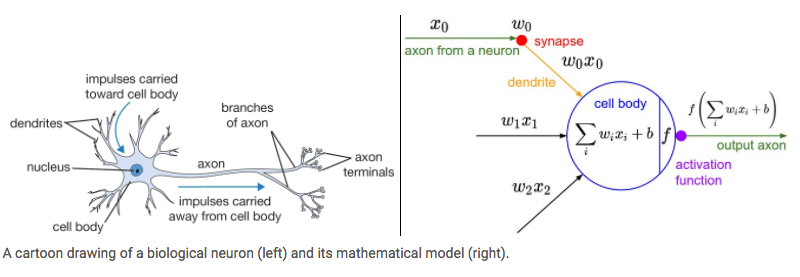

In [4]:
Image('ud730_3_01.png')

Commonly used activation functions

- **Sigmoid** $σ(x)=1/(1+e^{−x})$ takes a real-valued number and “squashes” it into range between 0 and 1. It has a nice interpretation as the firing rate of a neuron: from not firing at all (0) to fully-saturated firing at an assumed maximum frequency (1).
- **ReLU** (the Rectified Linear Unit) f(x)=max(0,x). The activation is simply thresholded at zero. 

  - There are several pros and cons to using the ReLUs:

  - (+) It was found to greatly accelerate the convergence of stochastic gradient descent compared to the sigmoid/tanh functions. 
  - (+) Compared to tanh/sigmoid neurons that involve expensive operations (exponentials, etc.), the ReLU can be implemented by simply thresholding a matrix of activations at zero.
  - (-) ReLU units can be fragile during training and can be "broken". For example, a large gradient flowing through a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any data point again.

- **Leaky ReLU** is one attempt to fix the “dying ReLU” problem. Instead of the function being zero when x < 0, a leaky ReLU will have a small negative slope (of 0.01, or so). 

- **Maxout** &nbsp;  $f(w^T*x+b)$ where a non-linearity is applied on the dot product between the weights and the data. The Maxout neuron computes the function $max(w^{T1}*x+b1,w^{T2}*x+b2)$. Notice that both ReLU and Leaky ReLU are a special case of this form (for example, for ReLU we have w1,b1=0). The Maxout neuron therefore enjoys all the benefits of a ReLU unit (linear regime of operation, no saturation) and does not have its drawbacks (dying ReLU). However, unlike the ReLU neurons it doubles the number of parameters for every single neuron, leading to a high total number of parameters.

**"2-layer" neural network.**
The first layer effectively consists of the set of weights and biases applied to X and passed through ReLUs. The output of this layer is fed to the next one, but is not observable outside the network, hence it is known as a hidden layer. The second layer consists of the weights and biases applied to these intermediate outputs, followed by the softmax function to generate probabilities.

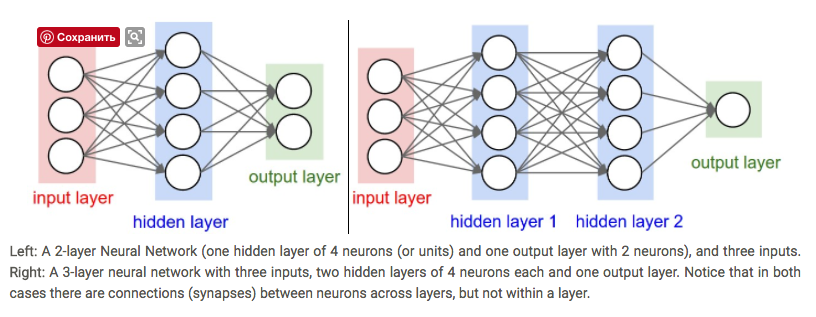

In [166]:
Image('ud730_3_02.png')

**Regularization**

- **L2 regularization** can be implemented by penalizing the squared magnitude of all parameters directly in the objective. That is, for every weight w in the network, we add the term 1/2*λ*w^2 to the objective, where λ is the regularization strength. It is commonly known as weight decay (in academic communities - ridge regression or Tikhonov regularization).
- **L1 regularization**: for each weight w we add the term λ∣w∣ to the objective. It is possible to combine the L1 regularization with the L2 regularization: λ1∣w∣+λ2w2 (this is called Elastic net regularization). The L1 regularization has the intriguing property that it leads the weight vectors to become sparse during optimization (i.e. very close to exactly zero). In other words, neurons with L1 regularization end up using only a sparse subset of their most important inputs and become nearly invariant to the “noisy” inputs. 
- **Max norm constraints** is based on enforcing an absolute upper bound on the magnitude of the weight vector for every neuron and using projected gradient descent to enforce the constraint.
- **Dropout**
- **Bias regularization**
- **Per-layer regularization**

## Examples

In [5]:
# http://cs231n.github.io/neural-networks-1/
# An example code for forward-propagating a single neuron
class Neuron(object):

    def forward(inputs):
        """ assume inputs and weights are 1-D numpy arrays and bias is a number """
        cell_body_sum = np.sum(inputs * self.weights) + self.bias
        firing_rate = 1.0 / (1.0 + math.exp(-cell_body_sum)) # sigmoid activation function
        return firing_rate

In [158]:
# https://www.packtpub.com/big-data-and-business-intelligence/python-machine-learning
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch 
        if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling 
        and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=10, 
               shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples 
            is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

         """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

In [13]:
iris = com.load_data('iris')

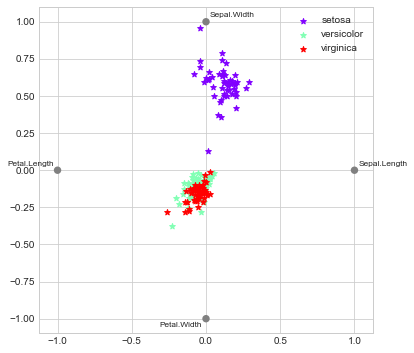

In [14]:
plt.figure(figsize=(6,6))
plt.style.use('seaborn-whitegrid')
radviz(iris, 'Species', marker='*', colormap=plt.cm.rainbow)

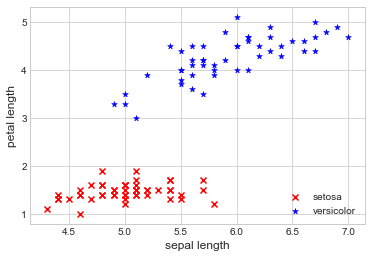

In [155]:
y = iris.iloc[0:100, 4].values
y = np.where(y == 'setosa', -1, 1)
X = iris.iloc[0:100, [0, 2]].values
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='x', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='*', label='versicolor')
plt.xlabel('sepal length')
plt.ylabel('petal length')
plt.legend(loc=4);

In [156]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

In [148]:
def plot_decision_regions(X, y, classifier, resolution=0.001):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    x2_min, x2_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

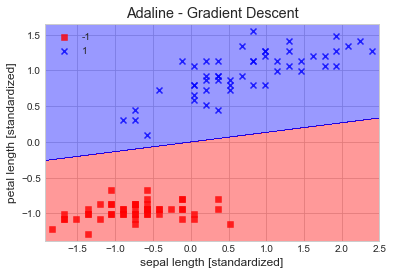

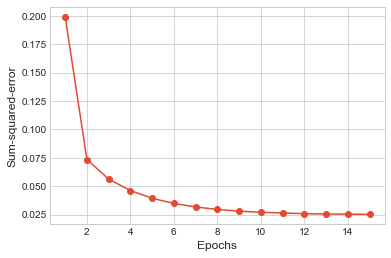

In [159]:
ada = AdalineSGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

In [ ]:
# forward-pass of a 3-layer neural network
f = lambda x: 1.0/(1.0 + np.exp(-x)) # activation function (sigmoid)
x = np.random.randn(3, 1) # random input vector of three numbers (3x1)
h1 = f(np.dot(W1, x) + b1) # calculate first hidden layer activations (4x1)
h2 = f(np.dot(W2, h1) + b2) # calculate second hidden layer activations (4x1)
out = np.dot(W3, h2) + b3 # output neuron (1x1)

In [ ]:
# http://cs231n.github.io/neural-networks-2/
""" 
Inverted Dropout: Recommended implementation example.
We drop and scale at train time and don't do anything at test time.
"""

p = 0.5 # probability of keeping a unit active. higher = less dropout

def train_step(X):
    # forward pass for example 3-layer neural network
    H1 = np.maximum(0, np.dot(W1, X) + b1)
    U1 = (np.random.rand(*H1.shape) < p) / p # first dropout mask. Notice /p!
    H1 *= U1 # drop!
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    U2 = (np.random.rand(*H2.shape) < p) / p # second dropout mask. Notice /p!
    H2 *= U2 # drop!
    out = np.dot(W3, H2) + b3
  
    # backward pass: compute gradients... (not shown)
    # perform parameter update... (not shown)

def predict(X):
    # ensembled forward pass
    H1 = np.maximum(0, np.dot(W1, X) + b1) # no scaling necessary
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    out = np.dot(W3, H2) + b3

In [165]:
# Generate a random n-class classification problem
X1, y1 = datasets.make_classification(n_samples=100000, n_features=20, n_informative=2, n_redundant=2)

## Quizes

In [41]:
# Quiz: Number Of Parameters
28*28*10 + 10

7850

In [42]:
# Quiz: Rectified Linear Units
# N2

In [4]:
# Quiz: Regularization Quiz
# W

##   &#x1F916; &nbsp; <span style="color:red">Assignment 2: Stochastic Gradient Descent</span>

In [35]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [36]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [14]:
def run_test(num_steps):

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

In [15]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [270]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [273]:
num_steps = 801

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 17.995188
Training accuracy: 9.3%
Validation accuracy: 12.4%
Loss at step 100: 2.269382
Training accuracy: 72.3%
Validation accuracy: 69.9%
Loss at step 200: 1.827889
Training accuracy: 75.0%
Validation accuracy: 72.5%
Loss at step 300: 1.584858
Training accuracy: 76.7%
Validation accuracy: 73.4%
Loss at step 400: 1.420621
Training accuracy: 77.5%
Validation accuracy: 73.9%
Loss at step 500: 1.299273
Training accuracy: 78.1%
Validation accuracy: 74.2%
Loss at step 600: 1.204808
Training accuracy: 78.7%
Validation accuracy: 74.4%
Loss at step 700: 1.128658
Training accuracy: 79.0%
Validation accuracy: 74.6%
Loss at step 800: 1.065592
Training accuracy: 79.5%
Validation accuracy: 74.8%
Test accuracy: 82.6%


In [277]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [278]:
run_test(3001)

Initialized
Minibatch loss at step 0: 20.161942
Minibatch accuracy: 7.0%
Validation accuracy: 6.5%
Minibatch loss at step 500: 1.367424
Minibatch accuracy: 78.9%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 1.228926
Minibatch accuracy: 78.1%
Validation accuracy: 76.9%
Minibatch loss at step 1500: 0.827879
Minibatch accuracy: 81.2%
Validation accuracy: 77.4%
Minibatch loss at step 2000: 0.680603
Minibatch accuracy: 87.5%
Validation accuracy: 76.8%
Minibatch loss at step 2500: 0.850101
Minibatch accuracy: 78.9%
Validation accuracy: 78.5%
Minibatch loss at step 3000: 1.062622
Minibatch accuracy: 78.9%
Validation accuracy: 78.8%
Test accuracy: 86.0%


Problem

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. This model should improve your validation / test accuracy.

In [279]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes], stddev=0.05))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels], stddev=0.05))
    biases1 = tf.Variable(tf.constant(0.01, shape=[hidden_nodes]))
    biases2 = tf.Variable(tf.constant(0.01, shape=[num_labels]))

    # Training computation.   
    
    train_hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    train_logits = tf.matmul(train_hidden, weights2) + biases2
    
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_logits = tf.matmul(valid_hidden, weights2) + biases2
    
    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_logits = tf.matmul(test_hidden, weights2) + biases2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits))
    
    # Optimizer.
    # Note: altering step size can lead to NaNs in matrices
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(train_logits)    
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)

In [281]:
run_test(5001)

Initialized
Minibatch loss at step 0: 2.409744
Minibatch accuracy: 14.1%
Validation accuracy: 10.4%
Minibatch loss at step 500: 0.575267
Minibatch accuracy: 85.9%
Validation accuracy: 80.6%
Minibatch loss at step 1000: 0.707600
Minibatch accuracy: 77.3%
Validation accuracy: 81.8%
Minibatch loss at step 1500: 0.454853
Minibatch accuracy: 84.4%
Validation accuracy: 82.6%
Minibatch loss at step 2000: 0.489108
Minibatch accuracy: 88.3%
Validation accuracy: 83.2%
Minibatch loss at step 2500: 0.489600
Minibatch accuracy: 85.9%
Validation accuracy: 83.4%
Minibatch loss at step 3000: 0.670857
Minibatch accuracy: 82.8%
Validation accuracy: 83.7%
Minibatch loss at step 3500: 0.548187
Minibatch accuracy: 84.4%
Validation accuracy: 83.9%
Minibatch loss at step 4000: 0.479213
Minibatch accuracy: 85.9%
Validation accuracy: 84.1%
Minibatch loss at step 4500: 0.492609
Minibatch accuracy: 85.2%
Validation accuracy: 84.2%
Minibatch loss at step 5000: 0.493095
Minibatch accuracy: 84.4%
Validation accurac

##   &#x1F916; &nbsp; <span style="color:red">Assignment 3:  Regularization</span>

Problem 1

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.

Problem 2

Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

Problem 3

Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.
What happens to our extreme overfitting case?

Problem 4

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.
One avenue you can explore is to add multiple layers.
Another one is to use learning rate decay:
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

### Problem 1 Regularization

In [282]:
batch_size = 128
parameter = 0.00001       

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels], stddev=0.05))
    biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Regularization.
    regularizers = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
    loss += parameter * regularizers

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [283]:
run_test(3001)

Initialized
Minibatch loss at step 0: 2.428626
Minibatch accuracy: 8.6%
Validation accuracy: 19.0%
Minibatch loss at step 500: 0.489876
Minibatch accuracy: 87.5%
Validation accuracy: 81.8%
Minibatch loss at step 1000: 0.655161
Minibatch accuracy: 79.7%
Validation accuracy: 82.1%
Minibatch loss at step 1500: 0.488432
Minibatch accuracy: 82.8%
Validation accuracy: 82.5%
Minibatch loss at step 2000: 0.566033
Minibatch accuracy: 89.1%
Validation accuracy: 82.6%
Minibatch loss at step 2500: 0.571475
Minibatch accuracy: 83.6%
Validation accuracy: 82.6%
Minibatch loss at step 3000: 0.710706
Minibatch accuracy: 83.6%
Validation accuracy: 82.7%
Test accuracy: 89.7%


In [286]:
batch_size = 128
hidden_nodes = 1024
parameter = 0.00001 

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes], stddev=0.05))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels], stddev=0.05))
    biases1 = tf.Variable(tf.constant(0.01, shape=[hidden_nodes]))
    biases2 = tf.Variable(tf.constant(0.01, shape=[num_labels]))

    # Training computation.   
    
    train_hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    train_logits = tf.matmul(train_hidden, weights2) + biases2
    
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_logits = tf.matmul(valid_hidden, weights2) + biases2
    
    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_logits = tf.matmul(test_hidden, weights2) + biases2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits))
    
    # Regularization.
    regularizers = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) \
    + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(biases2)
    loss += parameter * regularizers
    
  
    # Optimizer.
    # Note: altering step size can lead to NaNs in matrices
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(train_logits)    
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)

In [287]:
run_test(3001)

Initialized
Minibatch loss at step 0: 2.409239
Minibatch accuracy: 12.5%
Validation accuracy: 12.2%
Minibatch loss at step 500: 0.612640
Minibatch accuracy: 83.6%
Validation accuracy: 80.2%
Minibatch loss at step 1000: 0.705596
Minibatch accuracy: 79.7%
Validation accuracy: 81.6%
Minibatch loss at step 1500: 0.464150
Minibatch accuracy: 84.4%
Validation accuracy: 82.5%
Minibatch loss at step 2000: 0.499061
Minibatch accuracy: 88.3%
Validation accuracy: 83.0%
Minibatch loss at step 2500: 0.499284
Minibatch accuracy: 83.6%
Validation accuracy: 83.4%
Minibatch loss at step 3000: 0.693220
Minibatch accuracy: 84.4%
Validation accuracy: 83.6%
Test accuracy: 90.5%


### Problem 2 Overfitting

In [288]:
batch_size = 7
parameter = 0.00001       

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels], stddev=0.05))
    biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Regularization
    regularizers = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
    loss += parameter * regularizers

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [289]:
run_test(4001)

Initialized
Minibatch loss at step 0: 2.522008
Minibatch accuracy: 14.3%
Validation accuracy: 17.0%
Minibatch loss at step 500: 1.719914
Minibatch accuracy: 71.4%
Validation accuracy: 77.0%
Minibatch loss at step 1000: 0.633038
Minibatch accuracy: 85.7%
Validation accuracy: 77.7%
Minibatch loss at step 1500: 1.438251
Minibatch accuracy: 57.1%
Validation accuracy: 79.4%
Minibatch loss at step 2000: 0.070389
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Minibatch loss at step 2500: 0.857795
Minibatch accuracy: 71.4%
Validation accuracy: 79.4%
Minibatch loss at step 3000: 0.739077
Minibatch accuracy: 85.7%
Validation accuracy: 79.4%
Minibatch loss at step 3500: 0.347965
Minibatch accuracy: 85.7%
Validation accuracy: 79.5%
Minibatch loss at step 4000: 0.753678
Minibatch accuracy: 71.4%
Validation accuracy: 78.7%
Test accuracy: 85.6%


### Problem 3 Dropout

In [26]:
batch_size = 128
hidden_nodes = 1024
parameter = 0.0005 
dropout = 0.6

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes], stddev=0.05))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels], stddev=0.05))
    biases1 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases2 = tf.Variable(tf.constant(0.05, shape=[num_labels]))
    
    # Training computation with Dropout.   
    
    train_hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1), dropout)
    train_logits = tf.matmul(train_hidden, weights2) + biases2
    
    valid_hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), dropout)
    valid_logits = tf.matmul(valid_hidden, weights2) + biases2
    
    test_hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), dropout)
    test_logits = tf.matmul(test_hidden, weights2) + biases2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits))
    
    # Regularization.
    regularizers = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) \
    + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(biases2)
    loss += parameter * regularizers    
  
    # Optimizer.
    # Note: altering step size can lead to NaNs in matrices
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(train_logits)    
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)

In [27]:
run_test(3001)

Initialized
Minibatch loss at step 0: 3.092258
Minibatch accuracy: 7.8%
Validation accuracy: 12.2%
Minibatch loss at step 500: 0.845295
Minibatch accuracy: 89.8%
Validation accuracy: 82.2%
Minibatch loss at step 1000: 0.998232
Minibatch accuracy: 81.2%
Validation accuracy: 83.1%
Minibatch loss at step 1500: 0.743982
Minibatch accuracy: 87.5%
Validation accuracy: 83.8%
Minibatch loss at step 2000: 0.802600
Minibatch accuracy: 87.5%
Validation accuracy: 84.4%
Minibatch loss at step 2500: 0.796036
Minibatch accuracy: 85.2%
Validation accuracy: 84.3%
Minibatch loss at step 3000: 0.935748
Minibatch accuracy: 84.4%
Validation accuracy: 84.7%
Test accuracy: 91.7%


### Problem 4 Multi-layer Model

In [32]:
batch_size = 256
hidden_nodes = 1024
parameter = 0.0005 
dropout = 0.75

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes], stddev=0.05))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights3 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights4 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights5 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights6 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights7 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights8 = tf.Variable(tf.truncated_normal([hidden_nodes, hidden_nodes], stddev=0.05))
    weights9 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels], stddev=0.05))
    
    
    biases1 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases2 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases3 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases4 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases5 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases6 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases7 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases8 = tf.Variable(tf.constant(0.05, shape=[hidden_nodes]))
    biases9 = tf.Variable(tf.constant(0.05, shape=[num_labels]))
    
    # Training computation with Dropout.   
    
    train_hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1), dropout)
    train_hidden2 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden1, weights2) + biases2), dropout)
    train_hidden3 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden2, weights3) + biases3), dropout)
    train_hidden4 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden3, weights4) + biases4), dropout)
    train_hidden5 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden4, weights5) + biases5), dropout)
    train_hidden6 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden5, weights6) + biases6), dropout)
    train_hidden7 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden6, weights7) + biases7), dropout)
    train_hidden8 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_hidden7, weights8) + biases8), dropout)    
    train_logits = tf.matmul(train_hidden8, weights9) + biases9
    
    valid_hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), dropout)
    valid_hidden2 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden1, weights2) + biases2), dropout)
    valid_hidden3 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden2, weights3) + biases3), dropout)
    valid_hidden4 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden3, weights4) + biases4), dropout)
    valid_hidden5 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden4, weights5) + biases5), dropout)
    valid_hidden6 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden5, weights6) + biases6), dropout)
    valid_hidden7 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden6, weights7) + biases7), dropout)
    valid_hidden8 = tf.nn.dropout(tf.nn.relu(tf.matmul(valid_hidden7, weights8) + biases8), dropout)
    valid_logits = tf.matmul(valid_hidden8, weights9) + biases9
    
    test_hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), dropout)
    test_hidden2 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden1, weights2) + biases2), dropout)
    test_hidden3 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden2, weights3) + biases3), dropout)
    test_hidden4 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden3, weights4) + biases4), dropout)
    test_hidden5 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden4, weights5) + biases5), dropout)
    test_hidden6 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden5, weights6) + biases6), dropout)
    test_hidden7 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden6, weights7) + biases7), dropout)
    test_hidden8 = tf.nn.dropout(tf.nn.relu(tf.matmul(test_hidden7, weights8) + biases8), dropout)
    test_logits = tf.matmul(test_hidden8, weights9) + biases9
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=train_logits))
    
    # Regularization.
    regularizers = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) \
    + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(biases2) \
    + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(biases3) \
    + tf.nn.l2_loss(weights4) + tf.nn.l2_loss(biases4) \
    + tf.nn.l2_loss(weights5) + tf.nn.l2_loss(biases5) \
    + tf.nn.l2_loss(weights6) + tf.nn.l2_loss(biases6) \    
    + tf.nn.l2_loss(weights7) + tf.nn.l2_loss(biases7) \    
    + tf.nn.l2_loss(weights8) + tf.nn.l2_loss(biases8) \ 
    + tf.nn.l2_loss(weights9) + tf.nn.l2_loss(biases9)
    
    loss += parameter * regularizers    
  
    # Optimizer.
    # Note: altering step size can lead to NaNs in matrices
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(train_logits)    
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)    

In [33]:
run_test(10001)

Initialized
Minibatch loss at step 0: 5.011372
Minibatch accuracy: 9.0%
Validation accuracy: 12.9%
Minibatch loss at step 500: 2.512310
Minibatch accuracy: 81.2%
Validation accuracy: 81.6%
Minibatch loss at step 1000: 2.303329
Minibatch accuracy: 85.5%
Validation accuracy: 83.5%
Minibatch loss at step 1500: 2.368549
Minibatch accuracy: 84.0%
Validation accuracy: 84.0%
Minibatch loss at step 2000: 2.227824
Minibatch accuracy: 85.9%
Validation accuracy: 84.5%
Minibatch loss at step 2500: 2.222618
Minibatch accuracy: 82.0%
Validation accuracy: 85.3%
Minibatch loss at step 3000: 2.170179
Minibatch accuracy: 83.6%
Validation accuracy: 85.7%
Minibatch loss at step 3500: 2.065054
Minibatch accuracy: 85.9%
Validation accuracy: 86.2%
Minibatch loss at step 4000: 1.939641
Minibatch accuracy: 89.5%
Validation accuracy: 86.3%
Minibatch loss at step 4500: 2.008364
Minibatch accuracy: 85.9%
Validation accuracy: 86.5%
Minibatch loss at step 5000: 1.916206
Minibatch accuracy: 86.3%
Validation accuracy

### Another Example

In [6]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' 
                                % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' 
                               % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                    dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels


In [13]:
load_mnist('')
X_train, y_train = load_mnist('', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


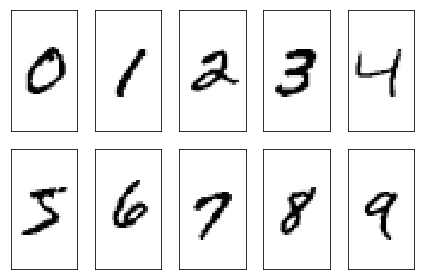

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

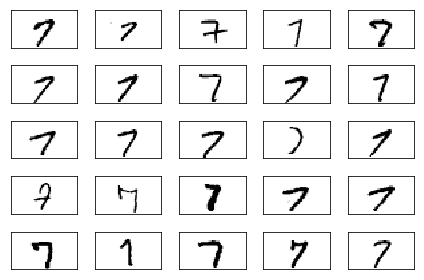

In [15]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

In [16]:
np.savetxt('train_img.csv', X_train, fmt='%i', delimiter=',')
np.savetxt('train_labels.csv', y_train, fmt='%i', delimiter=',')
np.savetxt('test_img.csv', X_test, fmt='%i', delimiter=',')
np.savetxt('test_labels.csv', y_test, fmt='%i', delimiter=',')

In [26]:
X_train = np.genfromtxt('train_img.csv', dtype=int, delimiter=',')
y_train = np.genfromtxt('train_labels.csv', dtype=int, delimiter=',')
X_test = np.genfromtxt('test_img.csv', dtype=int, delimiter=',')
y_test = np.genfromtxt('test_labels.csv', dtype=int, delimiter=',')

In [29]:
# https://www.packtpub.com/big-data-and-business-intelligence/python-machine-learning
class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001, 
                 alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,       
                     size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                     size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        # expit is equivalent to 1.0/(1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)

    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2)\
                + np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum()\
                + np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2

    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write(
                        '\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:,idx]

            mini = np.array_split(range(
                         y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(
                                     X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                            a3=a3, z2=z2,
                                            y_enc=y_enc[:, idx],
                                            w1=self.w1,
                                            w2=self.w2)

                # update weights
                delta_w1, delta_w2 = self.eta * grad1,\
                                     self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [30]:
nn = NeuralNetMLP(n_output=10, n_features=X_train.shape[1], n_hidden=50, 
                  l2=0.1, l1=0.0, epochs=1000, 
                  eta=0.001, alpha=0.001, decrease_const=0.00001,
                  shuffle=True, minibatches=50, random_state=1)

In [31]:
nn.fit(X_train, y_train, print_progress=True)

Epoch: 1000/1000

In [32]:
y_train_predict = nn.predict(X_train)
train_accuracy = np.sum(y_train == y_train_predict, axis=0) / X_train.shape[0]
print('Train accuracy: %.2f%%' % (train_accuracy * 100))

Train accuracy: 97.75%


In [34]:
y_test_predict = nn.predict(X_test)
test_accuracy = np.sum(y_test == y_test_predict, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (test_accuracy * 100))

Test accuracy: 95.81%


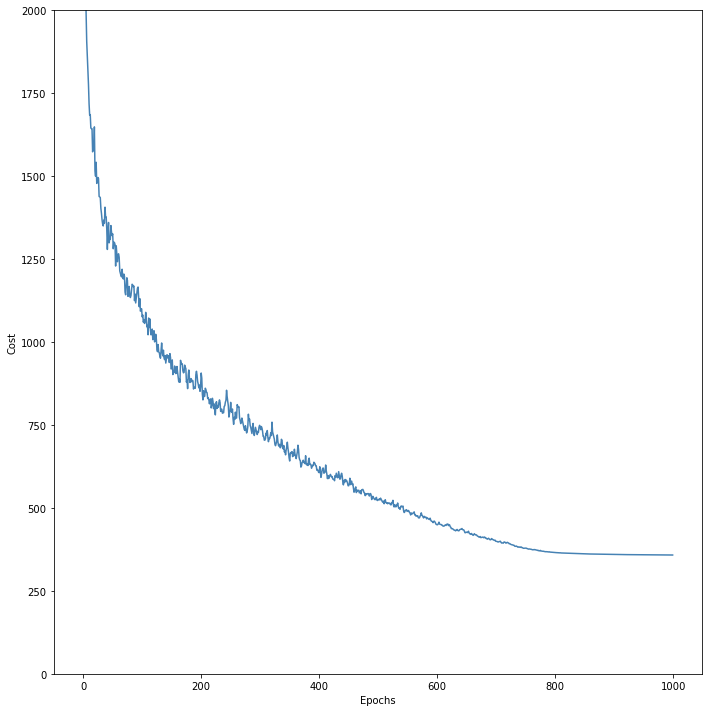

In [44]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.figure(figsize=(10,10))
plt.plot(range(len(cost_avgs)), cost_avgs, color='steelblue')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()

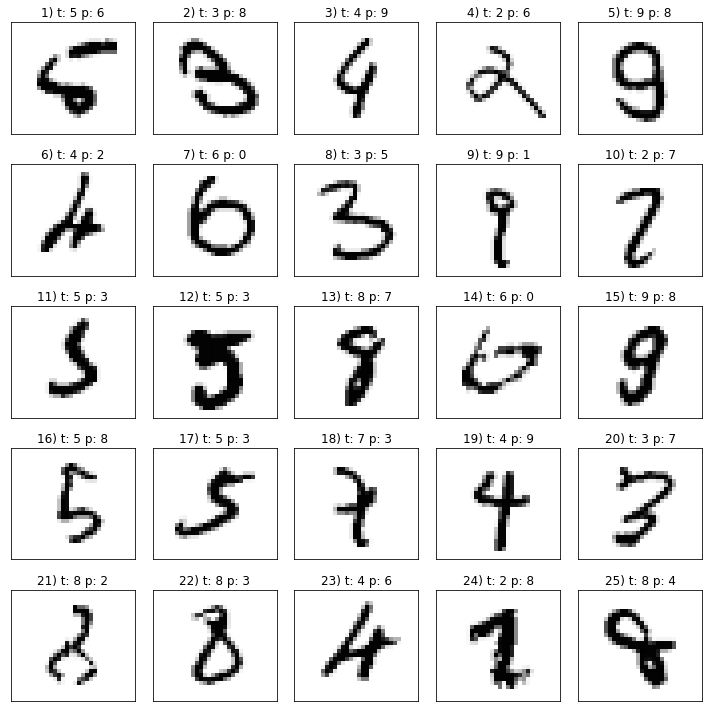

In [51]:
miscl_img = X_test[y_test != y_test_predict][:25]
correct_lab = y_test[y_test != y_test_predict][:25]
miscl_lab= y_test_predict[y_test != y_test_predict][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10,10))
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

In [38]:
train_labels2 = np.array([ np.where(r==1)[0][0] for r in train_labels ])
train_labels2[:5]

array([4, 9, 6, 2, 7])

In [39]:
test_labels2 = np.array([ np.where(r==1)[0][0] for r in test_labels ])
test_labels2[:5]

array([3, 6, 4, 7, 7])

In [40]:
nn2 = NeuralNetMLP(n_output=10, n_features=train_dataset.shape[1], n_hidden=50, 
                  l2=0.01, l1=0.0, epochs=1000, 
                  eta=0.001, alpha=0.001, decrease_const=0.00001,
                  shuffle=True, minibatches=50, random_state=1)

In [41]:
nn2.fit(train_dataset, train_labels2, print_progress=True)

Epoch: 1000/1000

In [42]:
y_train_predict2 = nn2.predict(train_dataset)
train_accuracy2 = np.sum(train_labels2 == y_train_predict2, axis=0) / train_dataset.shape[0]
print('Train accuracy: %.2f%%' % (train_accuracy2 * 100))

Train accuracy: 90.67%


In [43]:
y_test_predict2 = nn2.predict(test_dataset)
test_accuracy2 = np.sum(test_labels2 == y_test_predict2, axis=0) / test_dataset.shape[0]
print('Train accuracy: %.2f%%' % (test_accuracy2 * 100))

Train accuracy: 93.11%
